# Analysis

In [235]:
# importing all necessary libraries

# pip install -r requirements.txt

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from datetime import datetime, timedelta
import statsmodels.api as sm
import gc
from pylab import rcParams
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import gc
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import lightgbm as lgb
import calendar

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
import multiprocessing as mp
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Load data

In [236]:
# Reading datasets

train = pd.read_csv('input/train_ready.csv')
test = pd.read_csv('output/test_results.csv')
fcst = pd.read_csv('output/fcst_results.csv')

train_data = train.loc[train['id'] < '2023']
train_data = train_data.groupby(['id']).sum().reset_index()

In [237]:
# Concat objects

train_test = pd.concat([train_data, test, fcst], axis = 0)

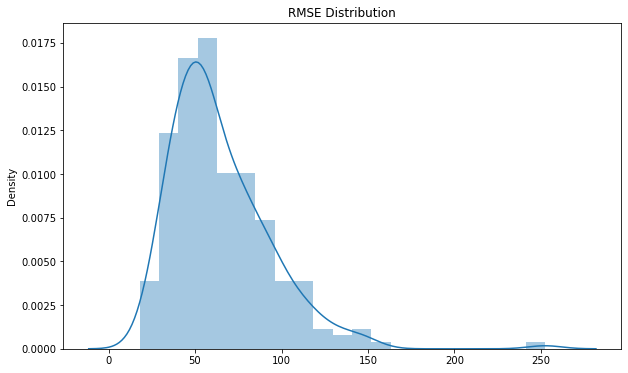

In [238]:
# Plot error distribution by product_number

plt.figure(figsize=(10, 6))
sns.distplot(pn_rmse['rmse'].values).set(title='RMSE Distribution')
plt.show()

# Evaluate Results

In [239]:
# Format to get a date

train_test = train_test
train_test["date"] = train_test["id"].str.split("-").str[0]
train_test["product_number"] = train_test["id"].str.split("-").str[1]
train_test['date'] = pd.to_datetime(train_test['date'] + '-0', format='%Y%W-%w')
train_test = train_test[["id", "date", "product_number", "sales_units", "inventory_units", "predictions"]]

# Max dates

max_train = "2023-01-08"
max_test = "2023-05-07"

In [240]:
# Aux function

def calculate_rmse(group):
    rmse = np.sqrt(mean_squared_error(group['inventory_units'], group['predictions']))
    return rmse

In [241]:
# Build tables for train, test and future forecasted

test_rmse = train_test[(train_test['date'] > max_train) & (train_test['date'] <= max_test)]

# Global RMSE

global_rmse = mean_squared_error(test_rmse['inventory_units'], test_rmse['predictions'])
global_rmse = np.sqrt(global_rmse)
global_rmse

# RMSE by groups

pn_rmse = test_rmse.groupby('product_number')
pn_rmse = pn_rmse.apply(calculate_rmse).reset_index()
pn_rmse.columns = ['product_number', 'rmse']
test_rmse

,id,date,product_number,sales_units,inventory_units,predictions
208,202302-100674,2023-01-15,100674,35.0,210.0,149.176480
209,202302-101661,2023-01-15,101661,42.0,95.0,136.274350
210,202302-102648,2023-01-15,102648,50.0,127.0,69.669464
211,202302-103635,2023-01-15,103635,4.0,360.0,134.902660
212,202302-104622,2023-01-15,104622,12.0,78.0,259.015320
...,...,...,...,...,...,...
4081,202318-96726,2023-05-07,96726,187.0,171.0,145.711650
4082,202318-97713,2023-05-07,97713,2.0,55.0,62.586180
4083,202318-9870,2023-05-07,9870,96.0,101.0,141.478640
4084,202318-98700,2023-05-07,98700,63.0,142.0,119.848640


In [242]:
train_test.loc[train_test['inventory_units'].isna()]['id'].unique()
global_plot = train_test.groupby(['date', 'product_number']).sum().reset_index().replace(0,np.nan)
global_plot

,date,product_number,sales_units,inventory_units,predictions
0,2019-04-21,233919,2.000000,20.0,NaN
1,2019-04-28,233919,0.666667,43.0,NaN
2,2019-05-05,233919,3.000000,184.0,NaN
3,2019-05-12,233919,61.000000,219.0,NaN
4,2019-05-19,233919,32.000000,254.0,NaN
...,...,...,...,...,...
16668,2023-08-06,92778,55.000000,NaN,151.97490
16669,2023-08-06,93765,46.000000,NaN,137.19844
16670,2023-08-06,94752,75.000000,NaN,191.42978
16671,2023-08-06,9870,96.000000,NaN,124.45489


In [243]:
# Global plot

global_plot = train_test.loc[train_test['product_number'].isin(train_test.loc[train_test['inventory_units'].isna()]['product_number'].unique())]
global_plot = global_plot.groupby('date').sum().reset_index().replace(0,np.nan)
global_plot = global_plot.loc[global_plot['date'] >= '2022']

,date,sales_units,inventory_units,predictions
141,2022-01-02,1972.333333,5094.333333,NaN
142,2022-01-09,2048.666667,5169.333333,NaN
143,2022-01-16,2898.333333,5752.333333,NaN
144,2022-01-23,8988.000000,8746.666667,NaN
145,2022-01-30,2181.000000,5570.000000,NaN
...,...,...,...,...
220,2023-07-09,6812.666667,NaN,20089.690049
221,2023-07-16,6812.666667,NaN,20089.690049
222,2023-07-23,6812.666667,NaN,20089.690049
223,2023-07-30,6812.666667,NaN,20089.690049


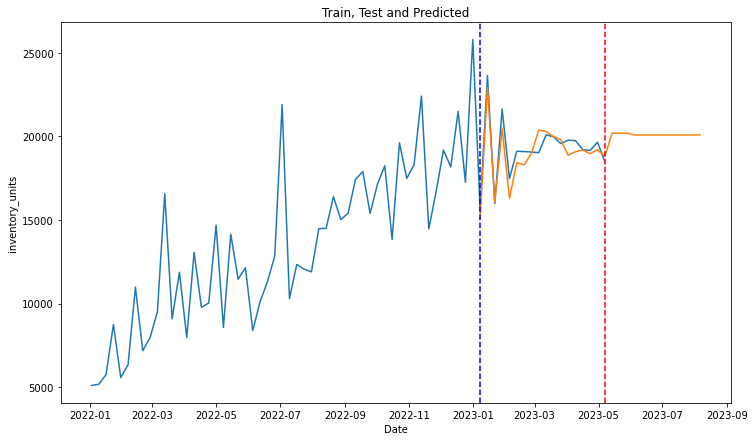

In [244]:
# Plot error distribution by product_number

plt.figure(figsize=(12, 7))
plt.plot(global_plot['date'].values, global_plot['inventory_units'].values, label = "inventory_units")
plt.plot(global_plot['date'].values, global_plot['predictions'].values, label = "predictions")
plt.axvline(pd.Timestamp(max_train),color='b', linestyle = 'dashed')
plt.axvline(pd.Timestamp(max_test),color='r', linestyle = 'dashed')
plt.xlabel('Date')
plt.ylabel('inventory_units')
plt.title('Train, Test and Predicted')
plt.show()

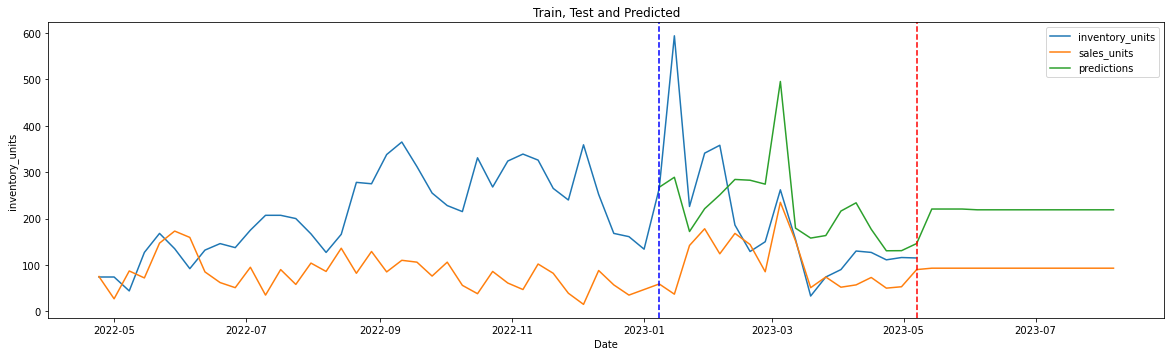

In [253]:
product_number = '99687'

plot_results = train_test[train_test['product_number'] == product_number]

# Time Series

plt.figure(figsize=(20,25))
plt.subplot(411)
plt.plot(plot_results['date'].values, plot_results['inventory_units'].values, label = "inventory_units")
plt.plot(plot_results['date'].values, plot_results['sales_units'].values, label = "sales_units")
plt.plot(plot_results['date'].values, plot_results['predictions'].values, label = "predictions")
plt.axvline(pd.Timestamp(max_train),color='b', linestyle = 'dashed')
plt.axvline(pd.Timestamp(max_test),color='r', linestyle = 'dashed')
plt.xlabel('Date')
plt.ylabel('inventory_units')
plt.title('Train, Test and Predicted')
plt.legend()
plt.show()

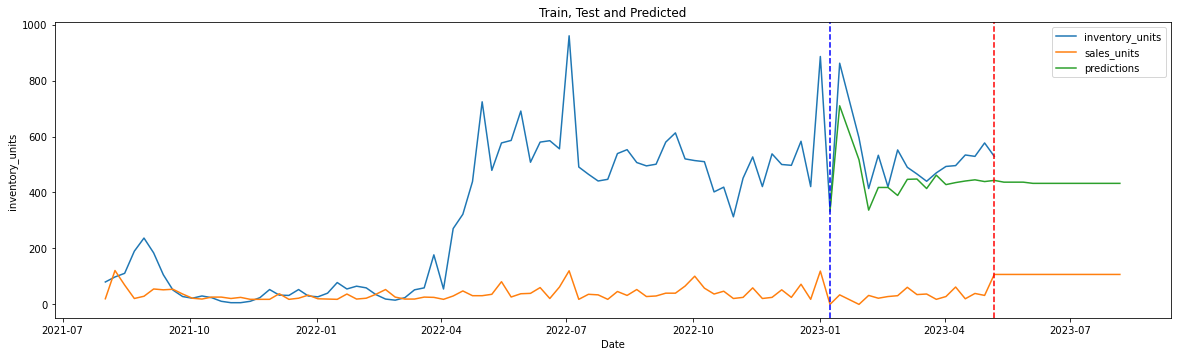

In [252]:
product_number = '58233'

plot_results = train_test[train_test['product_number'] == product_number]

# Time Series

plt.figure(figsize=(20,25))
plt.subplot(411)
plt.plot(plot_results['date'].values, plot_results['inventory_units'].values, label = "inventory_units")
plt.plot(plot_results['date'].values, plot_results['sales_units'].values, label = "sales_units")
plt.plot(plot_results['date'].values, plot_results['predictions'].values, label = "predictions")
plt.axvline(pd.Timestamp(max_train),color='b', linestyle = 'dashed')
plt.axvline(pd.Timestamp(max_test),color='r', linestyle = 'dashed')
plt.xlabel('Date')
plt.ylabel('inventory_units')
plt.title('Train, Test and Predicted')
plt.legend()
plt.show()

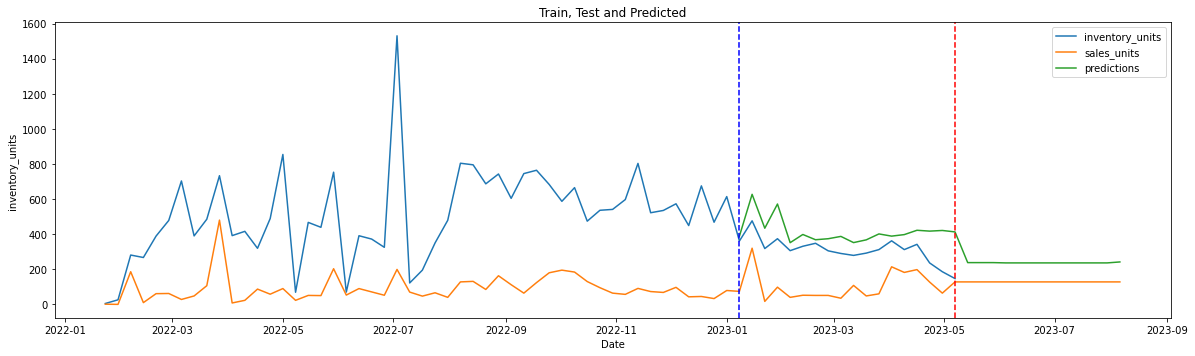

In [247]:
product_number = '112518'

plot_results = train_test[train_test['product_number'] == product_number]

# Time Series

plt.figure(figsize=(20,25))
plt.subplot(411)
plt.plot(plot_results['date'].values, plot_results['inventory_units'].values, label = "inventory_units")
plt.plot(plot_results['date'].values, plot_results['sales_units'].values, label = "sales_units")
plt.plot(plot_results['date'].values, plot_results['predictions'].values, label = "predictions")
plt.axvline(pd.Timestamp(max_train),color='b', linestyle = 'dashed')
plt.axvline(pd.Timestamp(max_test),color='r', linestyle = 'dashed')
plt.xlabel('Date')
plt.ylabel('inventory_units')
plt.title('Train, Test and Predicted')
plt.legend()
plt.show()

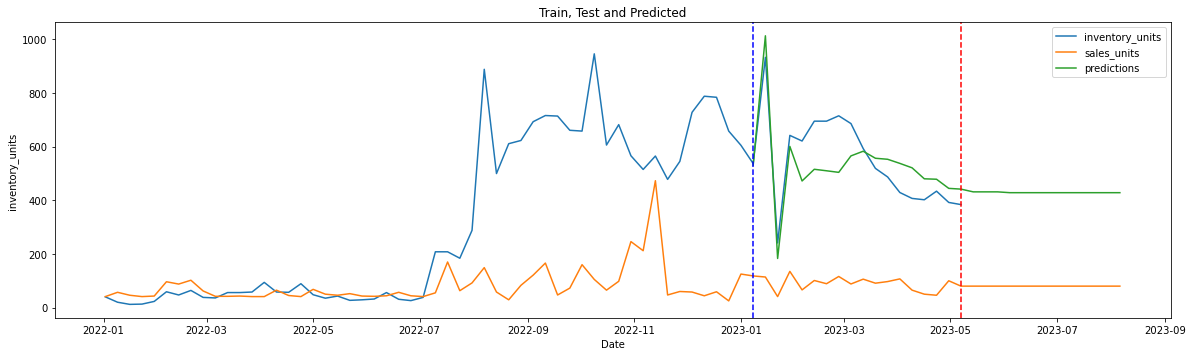

In [254]:
product_number = '75012'

plot_results = train_test[train_test['product_number'] == product_number]

# Time Series

plt.figure(figsize=(20,25))
plt.subplot(411)
plt.plot(plot_results['date'].values, plot_results['inventory_units'].values, label = "inventory_units")
plt.plot(plot_results['date'].values, plot_results['sales_units'].values, label = "sales_units")
plt.plot(plot_results['date'].values, plot_results['predictions'].values, label = "predictions")
plt.axvline(pd.Timestamp(max_train),color='b', linestyle = 'dashed')
plt.axvline(pd.Timestamp(max_test),color='r', linestyle = 'dashed')
plt.xlabel('Date')
plt.ylabel('inventory_units')
plt.title('Train, Test and Predicted')
plt.legend()
plt.show()

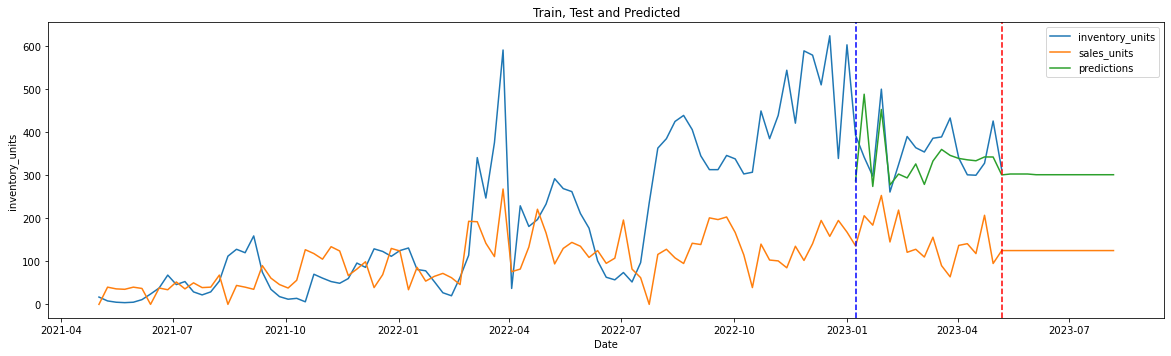

In [249]:
product_number = '45402'

plot_results = train_test[train_test['product_number'] == product_number]

# Time Series

plt.figure(figsize=(20,25))
plt.subplot(411)
plt.plot(plot_results['date'].values, plot_results['inventory_units'].values, label = "inventory_units")
plt.plot(plot_results['date'].values, plot_results['sales_units'].values, label = "sales_units")
plt.plot(plot_results['date'].values, plot_results['predictions'].values, label = "predictions")
plt.axvline(pd.Timestamp(max_train),color='b', linestyle = 'dashed')
plt.axvline(pd.Timestamp(max_test),color='r', linestyle = 'dashed')
plt.xlabel('Date')
plt.ylabel('inventory_units')
plt.title('Train, Test and Predicted')
plt.legend()
plt.show()

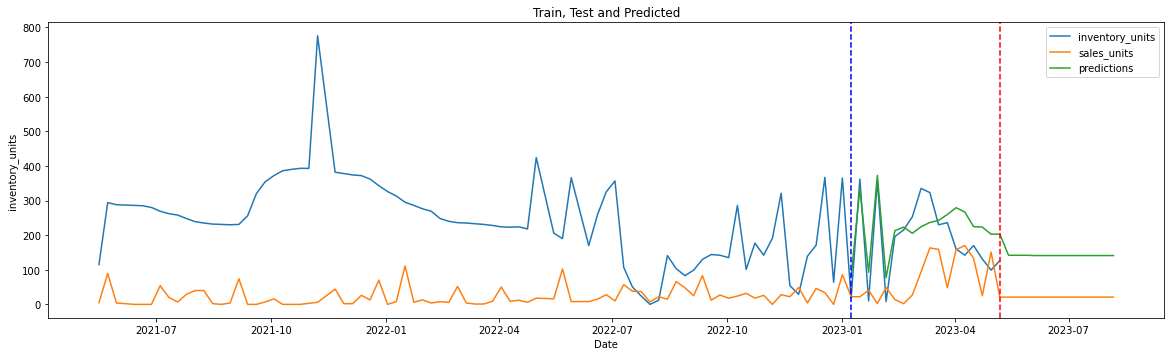

In [250]:
product_number = '240828'

plot_results = train_test[train_test['product_number'] == product_number]

# Time Series

plt.figure(figsize=(20,25))
plt.subplot(411)
plt.plot(plot_results['date'].values, plot_results['inventory_units'].values, label = "inventory_units")
plt.plot(plot_results['date'].values, plot_results['sales_units'].values, label = "sales_units")
plt.plot(plot_results['date'].values, plot_results['predictions'].values, label = "predictions")
plt.axvline(pd.Timestamp(max_train),color='b', linestyle = 'dashed')
plt.axvline(pd.Timestamp(max_test),color='r', linestyle = 'dashed')
plt.xlabel('Date')
plt.ylabel('inventory_units')
plt.title('Train, Test and Predicted')
plt.legend()
plt.show()